# Scenario Discovery

This part of the project will aim to identify certain scenarios that are relevant towards understanding the conditions of success for the flood risk management measures.

In [3]:
# importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import StandardScaler

from ema_workbench import (Model, RealParameter, ScalarOutcome)
from ema_workbench import MultiprocessingEvaluator, ema_logging, load_results
from ema_workbench.analysis import prim, dimensional_stacking

In [5]:
# loading the results from exploratory modelling
experiments, outcomes = load_results('./data/exploratory_results_40000_zero_policy.tar.gz')

In [7]:
# converting the experiments & outcomes to dataframes
experiments = pd.DataFrame(experiments)
outcomes = pd.DataFrame(outcomes)

In [9]:
# merging the dataframes
results = pd.concat([experiments, outcomes], axis = 1)

In [11]:
# slicing the uncertainties & levers from the experiments dataframe
uncertainties = experiments.iloc[:, :19]
levers = experiments.iloc[:, 19:50]

## PRIM

In the context of flood risk management, decision-makers, such as Rijkswaterstaat, must contend with various deep uncertainties. To support robust decision-making, scenario discovery was applied to identify the conditions under which proposed measures may fail. This follows Bryant and Lempert’s (2010) definition of scenarios as “sets of plausible future states of the world that represent vulnerabilities of proposed policies”.

To extract meaningful insights from the results, the Patient Rule Induction Method (PRIM) was applied. This method is useful as it is designed to find patterns in high dimensional & uncertain data. The output of this method are combinations of input parameter ranges (Boxes) that clearly describe under what conditions bad outcomes occur. This interpretability is crucial for decision-makers working in uncertain policy environments (Bryant & Lempert, 2010)  

**Rijkswaterstaat is tasked with safeguarding the Netherlands from water related threats**. Following consultations it became apparent that the main KPI to assess 'safeguarding' are the **expected number of deaths** & **expected annual damage**. The most critical being the amount of deaths. The analysis will therefore continue with this KPI. 

In [13]:
# assigning uncertainties as features & main kpi as outcome
X = uncertainties
y = outcomes['Expected Number of Deaths']

The preferance of Rijkswaterstaat was to meet specific thresholds, especially Density was considered important. To meet this the 85th percentile was chosen. This allowed for a high density metric while making the smallest tradeoff with the coverage metric.

In [15]:
# selecting the 85th percentile 
a = y.quantile(0.85)
Y = (y > a).astype(int).values

In [17]:
# setting the PRIM algorithm. A threhold of 0.8 ensures quality boxes by excluding boxes without 80% of data points greater than the 85th percentile
ema_logging.log_to_stderr(ema_logging.INFO)

prim_algorithm = prim.Prim(X, Y, threshold = 0.8)
box1 = prim_algorithm.find_box()

[MainProcess/INFO] 40000 points remaining, containing 6000 cases of interest
C:\Users\maxva\anaconda3\Lib\site-packages\ema_workbench\analysis\prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_paste.loc[i, u] = paste_value
[MainProcess/INFO] mean: 1.0, mass: 0.08085, coverage: 0.539, density: 1.0 restricted_dimensions: 4


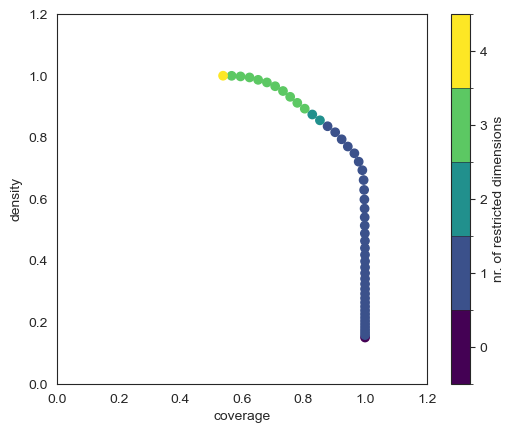

In [72]:
box1.show_tradeoff()
plt.show()

Density (y-axis) gives an indication to the amount of relevant cases within a box. When aiming for a high density, it means that Rijkswaterstaat is interested in considering as many cases as possible where the amount of deaths is unacceptable. If a box has a density of 0.9 it means that 90% of scenarios in the box produce a high amount of casualties. Therefore it can be assumed that the conditions found in these scenarios lead to policy failure.  

Coverage (x-axis) provides information about the percentage of all unacceptable cases that is found within the box. 

As mentioned before Rijkswaterstaat is interested in cases that produce an unacceptable amount of casualties. Therefore the scenario's of interest are those who have a high density. To find the optimal tradeoff, the coverage should not be too low. By consulting the tradeoff graph above, the filter ranges below are chosen. The goal is to produce scenario's with a high density (above 0.8) while maximising the coverage (between 0.8 & 0.9). 

In [27]:
# filtering the cases based on coverage and density metric, thereby creating a list of interesting cases
cases_of_interest = box1.peeling_trajectory
cases_of_interest = cases_of_interest[
    (cases_of_interest.coverage > 0.8) & 
    (cases_of_interest.coverage < 0.9) & 
    (cases_of_interest.density > 0.8)
]

In [29]:
# cases of interest are sorted by density
cases_of_interest = cases_of_interest.sort_values(by='density', ascending=False)
cases_of_interest

,coverage,density,id,k,mass,mean,n,res_dim
39,0.804167,0.893022,39,4825,0.135075,0.893022,5403,3
38,0.828667,0.874121,38,4972,0.142200,0.874121,5688,2
37,0.853500,0.855210,37,5121,0.149700,0.855210,5988,2
36,0.878333,0.835977,36,5270,0.157600,0.835977,6304,1


#### PRIM Results

Box 38 appears to produce the optimal tradeoff between density & coverage, **0.87 & 0.84** respectively. This means that the box explains 84% of all failure cases while comprising for 87% of failure cases. This means that it explaines fewer failures while being more precise. Furthermore 2 input parameters are restricted. Meaning two variables were dropped as they did not contribute significantly to the results.   

The most important input parameters or uncertainties are the probability of the dike withstanding the hydraulic load at locations A.1 and A.3. These are **A1_pfail** and **A3_pfail**. As seen below, both uncertainties are statistically significant. The plot below shows the box limits as blue lines with the blue number being the starting point. 

- **A1_pfail** : 
    - Blue Number: 0.097, this is the starting point of the uncertainty range. 
    - Blue Line: The limit that is identified by the PRIM box ranges from the blue number to 1.      
- **A3_pfail** :
    - Blue Number: 0.16, this is the starting point of the uncertainty range. 
    - Blue Line: The limit that is identified by the PRIM box ranges from the blue number to 1.

When looking the A1_pfail, the blue number suggests 9.7% of the original range have been retained. It is therefore tighly constrained while A3_pfail is slightly less constrained. This means that both uncertainties have been heavily restricted to filter scenarios that lead to the preferred outcome.  .


In [78]:
# case 38 is chosen
chosen_box = cases_of_interest[cases_of_interest['id'] == 38]
chosen_box_id = 38

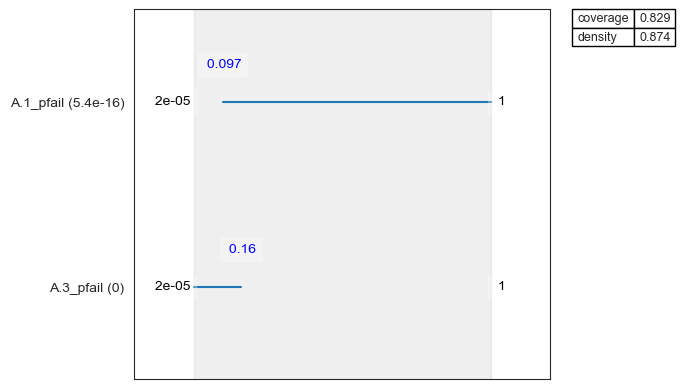

In [80]:
# box 38 is analysed further
box1.select(chosen_box_id)
box1.inspect(style='graph')
plt.show()

In [82]:
# ranges of uncertainties of case 38 are shown below
limits = box1.box_lims[chosen_box_id]
limits

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
0,0,30.000888,"{1.0, 10.0, 1.5}",0.096903,30.007855,"{1.5, 10.0, 1.0}",0.000014,30.000661,"{1.5, 10.0, 1.0}",0.000020,30.001156,"{1.0, 10.0, 1.5}",0.000015,30.007770,"{1.0, 10.0, 1.5}",0.000017,"{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}"
1,132,349.999971,"{1.0, 10.0, 1.5}",0.999982,349.997165,"{1.5, 10.0, 1.0}",0.999981,349.994008,"{1.5, 10.0, 1.0}",0.157599,349.997570,"{1.0, 10.0, 1.5}",0.999996,349.999333,"{1.0, 10.0, 1.5}",0.999977,"{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}"


In [37]:
# results are filtered
results_PRIM = results[
    (results['A.1_pfail'] >= limits['A.1_pfail'][0]) & (results['A.1_pfail'] <= limits['A.1_pfail'][1]) &
    (results['A.3_pfail'] >= limits['A.3_pfail'][0]) & (results['A.3_pfail'] <= limits['A.3_pfail'][1])
]

In [39]:
# policy & model columns are dropped and results are exported as csv
results_PRIM = results_PRIM.drop(columns=['policy', 'model'])
#results_box_numeric.to_csv('./data/prim_results_box.csv')

To support robust decision-making under uncertainty, a **subset of scenarios was selected from within the PRIM box** for further analysis. This box contains scenarios where failure is most likely. These scenarios were chosen based on the **best- and worst-case outcomes for the two chosen KPIs**: the Expected Number of Deaths and Expected Annual Damages. This ensures that both the most favorable and most adverse outcomes within this high-risk region are examined in greater detail. A diverse set of scenario's is selected.

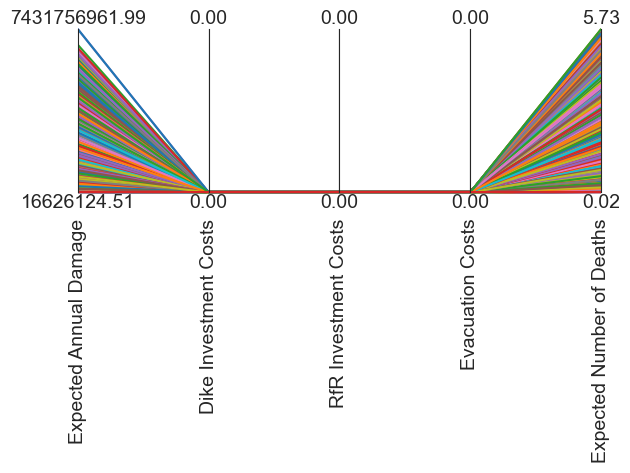

In [41]:
# parcoords plot is produced for the data
from ema_workbench.analysis import parcoords

data = pd.DataFrame({k:v for k,v in outcomes.items()})

indices = pd.concat([data.idxmax(), data.idxmin()]).unique()

limits = parcoords.get_limits(data)
axes = parcoords.ParallelAxes(limits)

axes.plot(data)
axes.plot(data.iloc[indices, :])
fig = plt.gcf()

plt.show()

In [93]:
# scaling the results
scaler = StandardScaler()
normalized_outcomes = scaler.fit_transform(results_PRIM[['Expected Number of Deaths', 'Expected Annual Damage']])

In [95]:
# printing the best and worst cases for both KPI's to achieve a diverse set of scenarios
print(results_PRIM['Expected Number of Deaths'].idxmax())
print(results_PRIM['Expected Annual Damage'].idxmax())
print(results_PRIM['Expected Number of Deaths'].idxmin())
print(results_PRIM['Expected Annual Damage'].idxmin())

6018
30634
33924
3924


In [63]:
# best and worst cases are saved in a new dataframe 
selected_scenarios = experiments.loc[[3924, 33924, 30634, 6018]]
selected_scenarios = selected_scenarios.drop(columns=['policy', 'model'])

In [67]:
# levers are dropped
selected_scenarios = selected_scenarios.drop(columns=['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1',
       'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1',
       'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1',
       'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1',
       'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1',
       'A.5_DikeIncrease 2'])

In [98]:
selected_scenarios

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2,scenario
3924,68,316.104078,1.0,0.822057,314.112844,1.5,0.009422,138.008081,10.0,0.154436,219.968529,10.0,0.225790,134.021403,10.0,0.055600,3.5,4.5,3.5,3924
33924,1,323.487208,10.0,0.865191,329.437335,1.0,0.001104,115.895260,1.0,0.051379,284.625448,1.0,0.597037,285.861230,10.0,0.935821,3.5,1.5,4.5,33924
30634,33,312.079524,1.5,0.312473,284.295637,10.0,0.049887,188.118806,10.0,0.001112,190.917729,10.0,0.879867,216.485322,10.0,0.856573,1.5,1.5,1.5,30634
6018,2,107.996484,10.0,0.329825,58.008564,1.0,0.020124,317.177960,1.5,0.076356,272.575279,10.0,0.402128,325.216193,1.0,0.319228,2.5,3.5,2.5,6018


In [69]:
# scenarios are exported as csv
selected_scenarios.to_csv('./data/Selected_Scenarios2.csv', index=False)